In [2]:
import tensorflow as tf
import pandas as pd


In [3]:
df= pd.read_csv("C:/Users/user/Desktop/code/python/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                parse_dates=["Date"],
                index_col= ["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
len(df)

2787

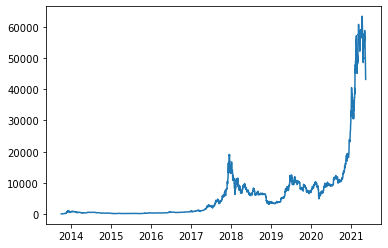

In [6]:
from os import X_OK
import matplotlib.pyplot as plt
x= df["Closing Price (USD)"]
plt.plot(x)
plt.show()

In [7]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [8]:
timesteps =bitcoin_prices.index.to_numpy()
prices =bitcoin_prices["Price"].to_numpy()
timesteps[:10]

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
       '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
       '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
       '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [9]:
split_size= int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]
len(X_train),len(y_train), len(X_test)

(2229, 2229, 558)

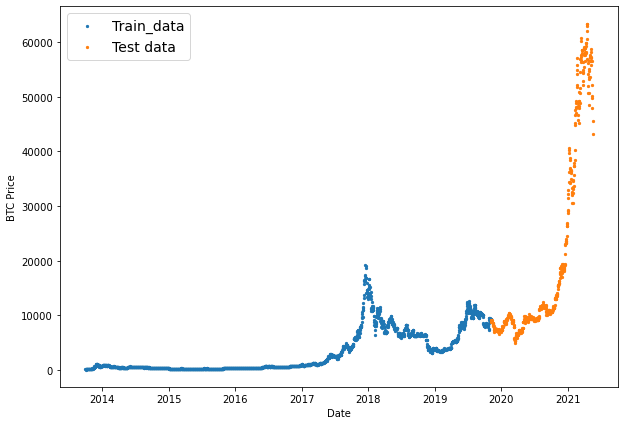

In [10]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train_data")
plt.scatter(X_test,y_test,s=5, label= "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()


In [11]:
def plot_time(timesteps, values,format= ".", start=0, end=None, label=None ):
    plt.plot(timesteps[start:end],values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

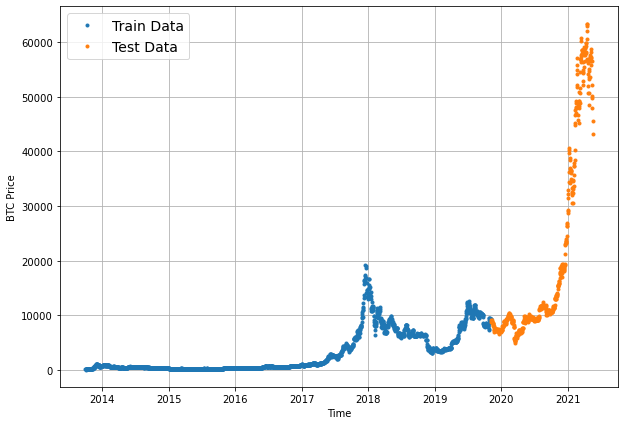

In [12]:
plt.figure(figsize= (10,7))
plot_time(timesteps= X_train, values=y_train, label="Train Data")
plot_time(timesteps= X_test, values= y_test,label="Test Data")

In [13]:
def mean_absolute_scaled_error(y_true, y_pred):
    mae= tf.reduce_mean(tf.abs(y_true-y_pred))

    mae_naive_no_season= tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1]))

    return mae/mae_naive_no_season


In [14]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    mae= tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse= tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse=tf.sqrt(mse)
    mape= tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase= mean_absolute_scaled_error(y_true,y_pred)
    
    return {"mae" : mae.numpy(),
            "mse" : mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}


In [15]:
naive_res= evaluate_preds(y_true=y_test[1:],y_pred=y_test[:-1])

naive_res

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [16]:
prices[:7], prices[7]

(array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ]),
 123.03299999999999)

In [17]:
HORIZON = 1
WINDOW_SIZE=7


In [18]:
def get_labelled_window(x, horizon=HORIZON):
    return x[:,:-horizon], x[:,-horizon:]

In [19]:
import numpy as np
test_window,test_label =get_labelled_window(tf.expand_dims(tf.range(8)+1,axis=0))
test_window.numpy()

array([[1, 2, 3, 4, 5, 6, 7]])

In [20]:
def make_windows(x, window_size=WINDOW_SIZE, horizon= HORIZON):

    window_step= np.expand_dims(np.arange(window_size+horizon),axis=0)

    window_indexes= window_step+ np.expand_dims(np.arange(len(x)-(window_size + horizon-1)),axis=0).T

    windowed_array= x[window_indexes]

    windows,labels= get_labelled_window(windowed_array,horizon=horizon)
    return windows,labels

In [21]:
full_windows, full_labels= make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [22]:
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [23]:
inp = prices[:-7]
target= prices[7:]
dataset= tf.keras.preprocessing.timeseries_dataset_from_array(inp,target,sequence_length=7)


In [24]:
def make_train_test_split(windows, labels, test_split=0.2):

    split_size= int(len(windows) * (1-test_split))
    train_windows= windows[:split_size]
    train_labels= labels[:split_size]
    test_windows= windows[split_size:]
    test_labels= labels[split_size:]
    return train_windows,test_windows,train_labels,test_labels

In [25]:
train_windows, test_windows,train_labels,test_labels = make_train_test_split(full_windows,full_labels)
len(train_windows),len(test_labels)

(2224, 556)

In [26]:
import os


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                            verbose=0, 
                                            save_best_only=True)


In [27]:
from gc import callbacks
from pickletools import optimize
import tensorflow
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")

], name="model_1_dense")

model_1.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['mae', 'mse'])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data =(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 4s 63ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 1s 58ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.2188 - val_loss: 1005.9992 - val_mae: 1005.9992 - val_mse: 3441833.5000
Epoch 3/100
18/18 [==============================] - 1s 38ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6094 - val_loss: 923.2863 - val_mae: 923.2863 - val_mse: 2868221.2500
Epoch 4/100
18/18 [==============================] - 1s 33ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5625 - val_loss: 900.5871 - val_mae: 900.5871 - val_mse: 2683715.0000
Epoch 5/100
18/18 [==============================] - 1s 39ms/step - loss: 165.0895 - mae: 165.0895 - mse: 145490.7812 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.0000
Epoch 6/100
18/18 [==============================] - 1s 47ms/step - loss: 158.5

In [28]:
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 7ms/step - loss: 585.9756 - mae: 585.9756 - mse: 1197802.0000


[585.9755859375, 585.9755859375, 1197802.0]

In [29]:
model_1= tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.7500


[568.9509887695312, 568.9509887695312, 1171743.75]

In [30]:
def make_preds(model, input_data):

    forecast= model.predict(input_data)
    return tf.squeeze(forecast)

In [31]:
model_1_preds= make_preds(model_1,test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 3ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.712, 8769.886, 9015.712, 8795.519, 8723.811, 8730.112,
        8691.953, 8502.054, 8460.96 , 8516.548], dtype=float32)>)

In [32]:
test_labels.shape

(556, 1)

In [33]:
models_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_1_preds)
models_1_results


{'mae': 568.95105,
 'mse': 1171743.6,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [34]:
naive_res

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

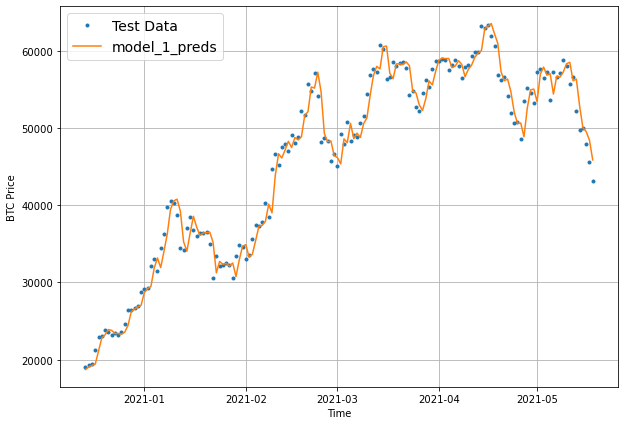

In [35]:
offset=400
plt.figure(figsize=(10,7))
plot_time(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")

plot_time(timesteps=X_test[-len(test_windows):],
         values=model_1_preds,
         start=offset,
         format="-",
         label='model_1_preds')

In [36]:
HORIZON=1
WINDOW_SIZE=30

full_windows,full_labels= make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows)

2757

In [37]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels,
                                                                               test_split=0.2)
len(train_windows),len(test_windows)


(2205, 552)

In [38]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

In [39]:
model_2.evaluate(test_windows,test_labels)


18/18 [==============================] - 0s 3ms/step - loss: 665.5611


665.5610961914062

In [40]:
model_2= tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 616.3276


616.3275756835938

In [41]:
model_2_preds= make_preds(model_2,input_data=test_windows)


18/18 [==============================] - 0s 2ms/step


In [42]:
test_labels.shape

(552, 1)

In [43]:
model_2_results= evaluate_preds(y_true= tf.squeeze(test_labels),y_pred=model_2_preds)
model_2_results

{'mae': 616.3275,
 'mse': 1309630.0,
 'rmse': 1144.3907,
 'mape': 2.8121033,
 'mase': 1.0773466}

In [44]:
models_1_results

{'mae': 568.95105,
 'mse': 1171743.6,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

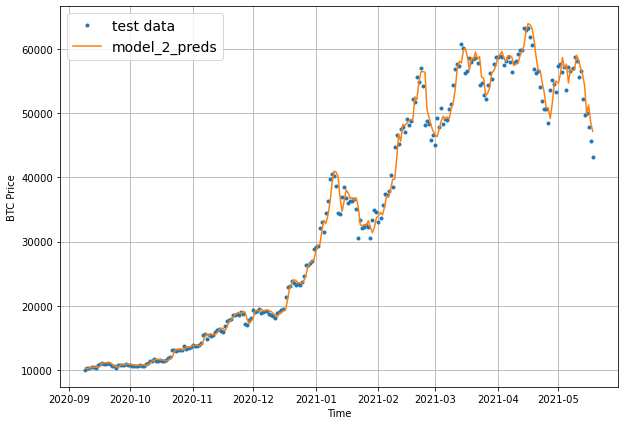

In [45]:
offset =300
plt.figure(figsize=(10,7))
plot_time(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="test data")

plot_time(timesteps=X_test[-len(test_windows):] ,values= model_2_preds,start=offset,format="-", label="model_2_preds")

In [46]:
HORIZON=7
WINDOW_SIZE=30

full_windows, full_labels = make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2751, 2751)

In [47]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(
    windows=full_windows, labels=full_labels)

len(train_windows),len(test_windows),len(train_labels)

(2200, 551, 2200)

In [48]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)

], name="model_3_dense")

model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels, batch_size=128,
            epochs=100,
            validation_data= (test_windows,test_labels),
            callbacks= [create_model_checkpoint(model_name=model_3.name)])


Epoch 1/100
18/18 [==============================] - 1s 53ms/step - loss: 1476.6752 - val_loss: 3088.5613
Epoch 2/100
18/18 [==============================] - 1s 46ms/step - loss: 552.8943 - val_loss: 2462.4548
Epoch 3/100
18/18 [==============================] - 1s 42ms/step - loss: 435.1978 - val_loss: 2283.1484
Epoch 4/100
18/18 [==============================] - 1s 53ms/step - loss: 391.9787 - val_loss: 1975.1218
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 357.9485 - val_loss: 2000.1556
Epoch 6/100
18/18 [==============================] - 1s 39ms/step - loss: 332.6704 - val_loss: 1723.4186
Epoch 7/100
18/18 [==============================] - 1s 45ms/step - loss: 309.9903 - val_loss: 1591.9688
Epoch 8/100
18/18 [==============================] - 1s 34ms/step - loss: 302.4123 - val_loss: 1579.8518
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 293.9170 - val_loss: 1602.9116
Epoch 10/100
18/18 [==============================] - 1s

In [49]:
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1300.1525


1300.1524658203125

In [50]:
model_3 =tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows,test_labels)


18/18 [==============================] - 0s 5ms/step - loss: 1237.5063


1237.50634765625

In [51]:
model_3_preds = make_preds(model_3, input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.89  , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ]], dtype=float32)>

In [52]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([551, 7]), TensorShape([552]))

In [53]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
        
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}


In [54]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1237.5063,
 'mse': 5405198.5,
 'rmse': 1425.7477,
 'mape': 5.5588784,
 'mase': 2.2020733}

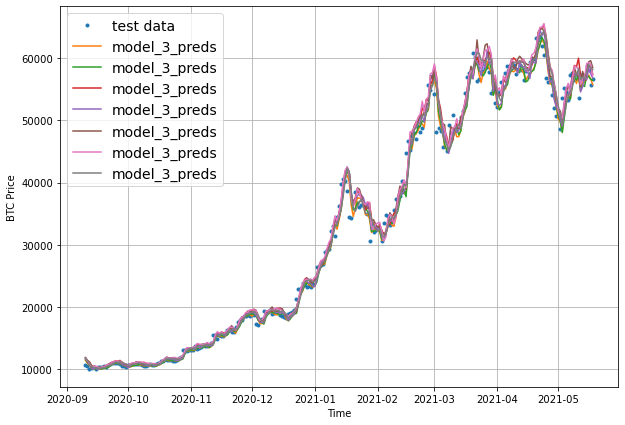

In [55]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time(timesteps=X_test[-len(test_windows):],
          values=test_labels[:, 0], start=offset, label="test data")

plot_time(timesteps=X_test[-len(test_windows):], values=model_3_preds,
          start=offset, format="-", label="model_3_preds")


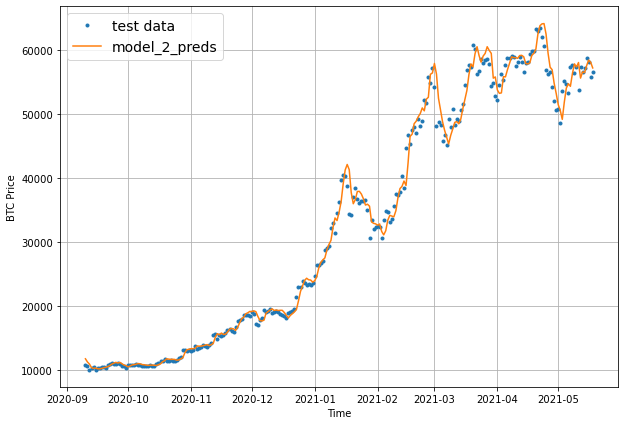

In [56]:
offset =300
plt.figure(figsize=(10,7))
plot_time(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="test data")

plot_time(timesteps=X_test[-len(test_windows):] ,values=tf.reduce_mean(model_3_preds,axis=1),start=offset,format="-", label="model_2_preds")

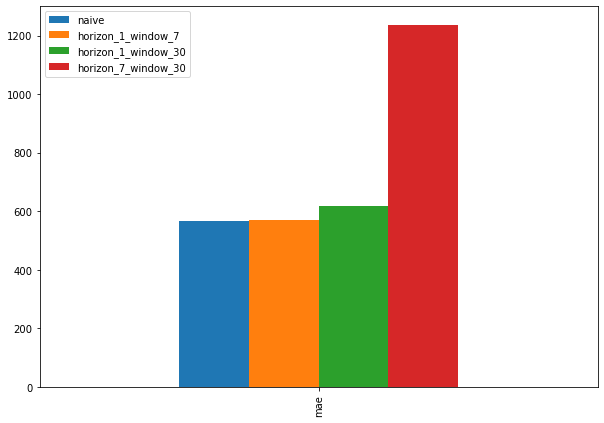

In [57]:
pd.DataFrame({"naive":naive_res["mae"],
"horizon_1_window_7": models_1_results["mae"],
"horizon_1_window_30":model_2_results["mae"],
"horizon_7_window_30":model_3_results["mae"]},index= ["mae"]).plot(figsize=(10,7),kind="bar")

In [58]:
HORIZON=1
WINDOW_SIZE=7

full_windows, full_labels= make_windows(prices,window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_labels),len(full_windows)

(2780, 2780)

In [59]:
train_windows,test_windows,train_labels,test_labels= make_train_test_split(full_windows,full_labels)
len(train_windows),len(test_labels)

(2224, 556)

In [60]:
train_windows[0].shape

(7,)

In [61]:
x=  tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [62]:
expand_dim_layer = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))
expand_dim_layer(x)

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[123.65499],
       [125.455  ],
       [108.58483],
       [118.67466],
       [121.33866],
       [120.65533],
       [121.795  ]], dtype=float32)>

In [63]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=7,
                  padding="causal", activation="relu"),
    layers.Dense(HORIZON)

], name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])


Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1486.8540

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 8s 97ms/step - loss: 1486.8540 - val_loss: 1494.0685
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 359.4668 - val_loss: 1882.3083
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 240.0226

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 64ms/step - loss: 237.6437 - val_loss: 1228.2827
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 208.4415

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 58ms/step - loss: 208.5991 - val_loss: 1095.6582
Epoch 5/100
 9/18 [==============>...............] - ETA: 0s - loss: 218.5226

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 197.1485 - val_loss: 1087.9990
Epoch 6/100
13/18 [====================>.........] - ETA: 0s - loss: 188.3407

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 192.2835 - val_loss: 1075.7545
Epoch 7/100
14/18 [======================>.......] - ETA: 0s - loss: 198.0395

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 191.2741 - val_loss: 1050.4601
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 186.0932 - val_loss: 1054.7797
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 183.6489 - val_loss: 1061.0856
Epoch 10/100
13/18 [====================>.........] - ETA: 0s - loss: 175.3409

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 181.0739 - val_loss: 1007.3293
Epoch 11/100
18/18 [==============================] - ETA: 0s - loss: 177.9125

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 54ms/step - loss: 177.9125 - val_loss: 986.4636
Epoch 12/100
18/18 [==============================] - 0s 7ms/step - loss: 177.0196 - val_loss: 1027.5632
Epoch 13/100
18/18 [==============================] - 0s 8ms/step - loss: 173.0899 - val_loss: 998.0865
Epoch 14/100
12/18 [===================>..........] - ETA: 0s - loss: 164.1840

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 62ms/step - loss: 169.1068 - val_loss: 957.6586
Epoch 15/100
10/18 [===============>..............] - ETA: 0s - loss: 166.0920

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 53ms/step - loss: 168.9441 - val_loss: 951.0868
Epoch 16/100
10/18 [===============>..............] - ETA: 0s - loss: 163.3472

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 54ms/step - loss: 162.9818 - val_loss: 910.6179
Epoch 17/100
18/18 [==============================] - 0s 9ms/step - loss: 159.8224 - val_loss: 950.2710
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 158.4490 - val_loss: 932.6097
Epoch 19/100
10/18 [===============>..............] - ETA: 0s - loss: 155.6641

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 42ms/step - loss: 155.9717 - val_loss: 865.1636
Epoch 20/100
14/18 [======================>.......] - ETA: 0s - loss: 155.1942

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 41ms/step - loss: 152.4890 - val_loss: 851.0286
Epoch 21/100
10/18 [===============>..............] - ETA: 0s - loss: 159.1158

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 42ms/step - loss: 150.2419 - val_loss: 823.7583
Epoch 22/100
16/18 [=========================>....] - ETA: 0s - loss: 149.0134

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 59ms/step - loss: 146.5942 - val_loss: 817.5502
Epoch 23/100
15/18 [========================>.....] - ETA: 0s - loss: 143.0672

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 45ms/step - loss: 143.0213 - val_loss: 815.2191
Epoch 24/100
13/18 [====================>.........] - ETA: 0s - loss: 140.5427

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 41ms/step - loss: 142.4472 - val_loss: 811.6649
Epoch 25/100
12/18 [===================>..........] - ETA: 0s - loss: 145.0165

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 38ms/step - loss: 138.6825 - val_loss: 773.2653
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 137.9314

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 136.4112 - val_loss: 747.6426
Epoch 27/100
10/18 [===============>..............] - ETA: 0s - loss: 138.6364

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 55ms/step - loss: 135.5997 - val_loss: 736.6955
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 131.6787

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 40ms/step - loss: 131.8269 - val_loss: 729.3217
Epoch 29/100
16/18 [=========================>....] - ETA: 0s - loss: 129.4232

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 45ms/step - loss: 130.4352 - val_loss: 715.5737
Epoch 30/100
18/18 [==============================] - 0s 8ms/step - loss: 132.4180 - val_loss: 827.3418
Epoch 31/100
18/18 [==============================] - 0s 7ms/step - loss: 144.1670 - val_loss: 841.3746
Epoch 32/100
12/18 [===================>..........] - ETA: 0s - loss: 141.2756

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 46ms/step - loss: 136.0106 - val_loss: 699.7341
Epoch 33/100
18/18 [==============================] - 0s 10ms/step - loss: 127.9241 - val_loss: 703.1788
Epoch 34/100
10/18 [===============>..............] - ETA: 0s - loss: 127.1697

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 55ms/step - loss: 124.6079 - val_loss: 687.4135
Epoch 35/100
10/18 [===============>..............] - ETA: 0s - loss: 122.1687

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 43ms/step - loss: 122.7475 - val_loss: 679.9236
Epoch 36/100
18/18 [==============================] - 0s 10ms/step - loss: 125.2610 - val_loss: 723.9998
Epoch 37/100
13/18 [====================>.........] - ETA: 0s - loss: 124.3294

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 40ms/step - loss: 123.2823 - val_loss: 657.9590
Epoch 38/100
13/18 [====================>.........] - ETA: 0s - loss: 124.1883

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 38ms/step - loss: 121.4682 - val_loss: 653.3034
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 121.0963 - val_loss: 677.5060
Epoch 40/100
14/18 [======================>.......] - ETA: 0s - loss: 119.8153

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 37ms/step - loss: 118.3144 - val_loss: 649.8810
Epoch 41/100
14/18 [======================>.......] - ETA: 0s - loss: 121.4180

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 40ms/step - loss: 118.4313 - val_loss: 635.9150
Epoch 42/100
13/18 [====================>.........] - ETA: 0s - loss: 120.4263

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 38ms/step - loss: 121.4736 - val_loss: 633.3147
Epoch 43/100
18/18 [==============================] - 0s 10ms/step - loss: 116.5272 - val_loss: 652.6730
Epoch 44/100
14/18 [======================>.......] - ETA: 0s - loss: 116.0042

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 46ms/step - loss: 119.4422 - val_loss: 625.1489
Epoch 45/100
18/18 [==============================] - 0s 7ms/step - loss: 118.1001 - val_loss: 656.5295
Epoch 46/100
13/18 [====================>.........] - ETA: 0s - loss: 121.1135

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 39ms/step - loss: 117.7151 - val_loss: 618.1378
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 118.6838 - val_loss: 691.4001
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 116.0792 - val_loss: 641.4036
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 115.9599 - val_loss: 619.1441
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 116.6826 - val_loss: 619.1307
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 114.2372 - val_loss: 622.6338
Epoch 52/100
12/18 [===================>..........] - ETA: 0s - loss: 124.2229

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 44ms/step - loss: 116.6652 - val_loss: 609.0569
Epoch 53/100
18/18 [==============================] - 0s 8ms/step - loss: 115.7129 - val_loss: 623.0092
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 114.6851 - val_loss: 614.8851
Epoch 55/100
18/18 [==============================] - 0s 7ms/step - loss: 114.2360 - val_loss: 610.8499
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2769 - val_loss: 732.5936
Epoch 57/100
18/18 [==============================] - 0s 9ms/step - loss: 133.7723 - val_loss: 640.8218
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 122.2335 - val_loss: 662.8841
Epoch 59/100
15/18 [========================>.....] - ETA: 0s - loss: 112.9547

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 41ms/step - loss: 111.8640 - val_loss: 597.4777
Epoch 60/100
18/18 [==============================] - 0s 9ms/step - loss: 112.1637 - val_loss: 637.3141
Epoch 61/100
18/18 [==============================] - 0s 11ms/step - loss: 112.4486 - val_loss: 602.3150
Epoch 62/100
18/18 [==============================] - 0s 10ms/step - loss: 110.3270 - val_loss: 597.6085
Epoch 63/100
10/18 [===============>..............] - ETA: 0s - loss: 122.5684

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 41ms/step - loss: 113.5292 - val_loss: 596.5160
Epoch 64/100
18/18 [==============================] - 0s 8ms/step - loss: 112.1835 - val_loss: 661.0568
Epoch 65/100
17/18 [===========================>..] - ETA: 0s - loss: 116.0010

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 52ms/step - loss: 114.9117 - val_loss: 591.5356
Epoch 66/100
10/18 [===============>..............] - ETA: 0s - loss: 108.7181

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 50ms/step - loss: 112.4425 - val_loss: 588.0613
Epoch 67/100
18/18 [==============================] - 0s 11ms/step - loss: 109.1343 - val_loss: 635.2735
Epoch 68/100
18/18 [==============================] - 0s 10ms/step - loss: 115.2148 - val_loss: 730.8604
Epoch 69/100
18/18 [==============================] - 0s 8ms/step - loss: 130.5157 - val_loss: 694.6175
Epoch 70/100
11/18 [=================>............] - ETA: 0s - loss: 118.7464

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 51ms/step - loss: 117.3485 - val_loss: 582.7703
Epoch 71/100
18/18 [==============================] - 0s 9ms/step - loss: 111.7962 - val_loss: 605.1554
Epoch 72/100
10/18 [===============>..............] - ETA: 0s - loss: 111.0231

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 49ms/step - loss: 110.5302 - val_loss: 581.5661
Epoch 73/100
18/18 [==============================] - 0s 11ms/step - loss: 111.2924 - val_loss: 614.2628
Epoch 74/100
18/18 [==============================] - 0s 8ms/step - loss: 110.3729 - val_loss: 586.3537
Epoch 75/100
18/18 [==============================] - 0s 8ms/step - loss: 109.9528 - val_loss: 598.8422
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 111.0880 - val_loss: 584.3826
Epoch 77/100
17/18 [===========================>..] - ETA: 0s - loss: 110.6435

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 50ms/step - loss: 109.7770 - val_loss: 581.2430
Epoch 78/100
17/18 [===========================>..] - ETA: 0s - loss: 110.3119

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 49ms/step - loss: 109.4179 - val_loss: 578.7867
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 110.2761 - val_loss: 598.5275
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 108.8370 - val_loss: 595.3963
Epoch 81/100
13/18 [====================>.........] - ETA: 0s - loss: 105.4768

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 73ms/step - loss: 108.4690 - val_loss: 575.3317
Epoch 82/100
18/18 [==============================] - 0s 11ms/step - loss: 115.1399 - val_loss: 575.8415
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 112.0317 - val_loss: 684.0499
Epoch 84/100
18/18 [==============================] - 0s 9ms/step - loss: 116.1538 - val_loss: 584.0786
Epoch 85/100
18/18 [==============================] - 0s 10ms/step - loss: 109.5261 - val_loss: 575.6066
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 109.4162 - val_loss: 614.9030
Epoch 87/100
11/18 [=================>............] - ETA: 0s - loss: 112.2830

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 50ms/step - loss: 109.8334 - val_loss: 573.0805
Epoch 88/100
18/18 [==============================] - 0s 13ms/step - loss: 108.7679 - val_loss: 605.2974
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 110.9292 - val_loss: 581.9467
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 107.6792 - val_loss: 637.5426
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 113.2019 - val_loss: 615.0516
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 110.6723 - val_loss: 581.5013
Epoch 93/100
18/18 [==============================] - 0s 8ms/step - loss: 114.0798 - val_loss: 612.8642
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 109.8304 - val_loss: 579.2548
Epoch 95/100
13/18 [====================>.........] - ETA: 0s - loss: 107.5263

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 46ms/step - loss: 108.3462 - val_loss: 572.3138
Epoch 96/100
18/18 [==============================] - 0s 8ms/step - loss: 114.8912 - val_loss: 635.6722
Epoch 97/100
18/18 [==============================] - 0s 9ms/step - loss: 111.8816 - val_loss: 606.7851
Epoch 98/100
18/18 [==============================] - 0s 9ms/step - loss: 111.1247 - val_loss: 576.2915
Epoch 99/100
16/18 [=========================>....] - ETA: 0s - loss: 108.8019

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 50ms/step - loss: 109.7499 - val_loss: 570.7388
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.0033 - val_loss: 615.6099


In [64]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [65]:
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 12ms/step - loss: 615.6098


615.6098022460938

In [66]:
model_4= tf.keras.models.load_model("model_experiments/model_4_conv1D/")
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 570.7387


570.7387084960938

In [67]:
model_4_preds = make_preds(model_4,test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8893.43 , 8788.889, 9020.291, 8796.401, 8743.089, 8764.085,
       8680.324, 8538.85 , 8475.117, 8526.651], dtype=float32)>

In [68]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.7388,
 'mse': 1183499.8,
 'rmse': 1087.8877,
 'mape': 2.5461202,
 'mase': 1.00263}

In [69]:
models_1_results

{'mae': 568.95105,
 'mse': 1171743.6,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [70]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128,activation="relu")(x)
# x=layers.
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels))


Epoch 1/100
18/18 [==============================] - 2s 21ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 237.3967 - val_loss: 1298.9084
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 181.9180 - val_loss: 966.6430
Epoch 5/100
18/18 [==============================] - 0s 17ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 173.5414 - val_loss: 941.4746
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 170.3566 - val_loss: 898.5215
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 157.6712 - val_loss: 914.8641
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 166.5143 - val_loss: 1079.0775
Epoch 10/100
18/18 [==============================] - 0s 10ms/st

In [71]:
model_5= tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows,test_labels)

18/18 [==============================] - 2s 6ms/step - loss: 19694.8984


19694.8984375

In [72]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 1s 4ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([401.49185, 401.49185, 401.49185, 401.49185, 401.49185],
      dtype=float32)>

In [73]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results


{'mae': 19694.9,
 'mse': 695085060.0,
 'rmse': 26364.465,
 'mape': 96.632904,
 'mase': 34.598484}

In [74]:
block_reward_1= 50
block_reward_2= 25
block_reward_3= 12.5
block_reward_4= 6.25

block_reward_2_datetime= np.datetime64("2012-11-28")
block_reward_3_datetime= np.datetime64("2016-07-09")
block_reward_4_datetime= np.datetime64("2020-05-18")

In [75]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime-bitcoin_prices.index[0]).days

block_reward_3_days


2421

In [76]:
bitcoin_prices_block= bitcoin_prices.copy()
bitcoin_prices_block["block_reward"]=None

bitcoin_prices_block.iloc[:block_reward_2_days,-1]=block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1]=block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1]=block_reward_4
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


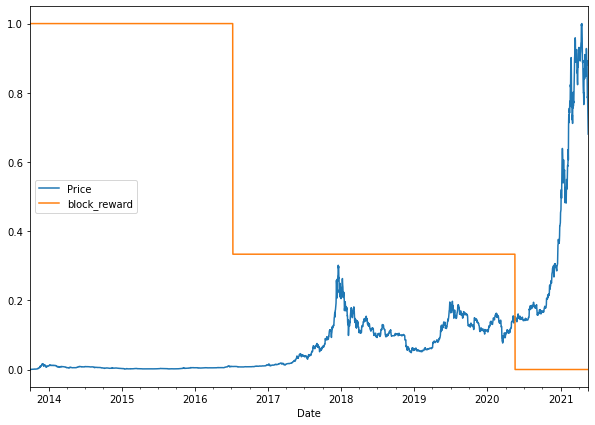

In [77]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),  # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));


In [78]:
HORIZON=1
WINDOW_SIZE=7

In [79]:
bitcoin_prices_windowed= bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f"Price + {i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head()

,Price,block_reward,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [80]:
X= bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y= bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [81]:
split_size= int(len(X)*0.8)
X_train,y_train = X[:split_size],y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train),len(y_test)

(2224, 556)

In [82]:
X_train.head()

,block_reward,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [83]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test,y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])


Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 813.5538 INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 41ms/step - loss: 708.7571 - val_loss: 2263.3035
Epoch 2/100
10/18 [===============>..............] - ETA: 0s - loss: 234.4329INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 39ms/step - loss: 209.3599 - val_loss: 882.9350
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 158.7038INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 155.8662 - val_loss: 819.8378
Epoch 4/100
10/18 [===============>..............] - ETA: 0s - loss: 159.7892INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 146.5632 - val_loss: 799.7484
Epoch 5/100
15/18 [========================>.....] - ETA: 0s - loss: 134.0419INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 50ms/step - loss: 132.3965 - val_loss: 693.0831
Epoch 6/100
14/18 [======================>.......] - ETA: 0s - loss: 123.0042INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 37ms/step - loss: 125.7849 - val_loss: 659.4670
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 122.0054 - val_loss: 715.4888
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 119.7870INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 120.0701 - val_loss: 636.3212
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 118.8690 - val_loss: 813.5287
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 142.6461 - val_loss: 798.1339
Epoch 11/100
18/18 [==============================] - 0s 6ms/step - loss: 132.8748 - val_loss: 954.1594
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 141.3553 - val_loss: 760.2547
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 121.1712 - val_loss: 744.8667
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 118.9032 - val_loss: 676.4731
Epoch 15/100
18/18 [==============================] - 0s 9ms/step - loss: 128.2026 - val_loss: 650.1197
Epoch 16/100
10/18 [===============>..............] - ETA: 0s - loss: 117.9232INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 48ms/step - loss: 120.1517 - val_loss: 607.5733
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3910 - val_loss: 613.7139
Epoch 18/100
13/18 [====================>.........] - ETA: 0s - loss: 118.0961INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 47ms/step - loss: 111.6833 - val_loss: 594.0025
Epoch 19/100
12/18 [===================>..........] - ETA: 0s - loss: 113.0931INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 50ms/step - loss: 115.6327 - val_loss: 587.0793
Epoch 20/100
18/18 [==============================] - 0s 9ms/step - loss: 108.1031 - val_loss: 610.2455
Epoch 21/100
18/18 [==============================] - 0s 10ms/step - loss: 113.3326 - val_loss: 746.6416
Epoch 22/100
15/18 [========================>.....] - ETA: 0s - loss: 124.7246INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 55ms/step - loss: 119.9599 - val_loss: 584.4871
Epoch 23/100
18/18 [==============================] - 0s 10ms/step - loss: 108.9238 - val_loss: 633.5175
Epoch 24/100
18/18 [==============================] - 0s 6ms/step - loss: 113.8530 - val_loss: 744.4082
Epoch 25/100
18/18 [==============================] - 0s 8ms/step - loss: 111.2092 - val_loss: 621.2402
Epoch 26/100
18/18 [==============================] - 0s 9ms/step - loss: 110.4809 - val_loss: 616.5059
Epoch 27/100
18/18 [==============================] - 0s 8ms/step - loss: 107.2301 - val_loss: 586.4800
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 107.9863INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 51ms/step - loss: 107.8962 - val_loss: 577.8256
Epoch 29/100
18/18 [==============================] - 0s 10ms/step - loss: 104.8487 - val_loss: 605.5060
Epoch 30/100
18/18 [==============================] - 0s 8ms/step - loss: 110.9190 - val_loss: 622.7371
Epoch 31/100
18/18 [==============================] - 0s 9ms/step - loss: 108.3989 - val_loss: 583.1699
Epoch 32/100
17/18 [===========================>..] - ETA: 0s - loss: 111.3495INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 66ms/step - loss: 110.4221 - val_loss: 574.4394
Epoch 33/100
18/18 [==============================] - 0s 8ms/step - loss: 109.4232 - val_loss: 584.2970
Epoch 34/100
18/18 [==============================] - 0s 9ms/step - loss: 106.3021 - val_loss: 681.6039
Epoch 35/100
18/18 [==============================] - 0s 9ms/step - loss: 110.6243 - val_loss: 685.6689
Epoch 36/100
18/18 [==============================] - 0s 8ms/step - loss: 113.9770 - val_loss: 589.9265
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 110.6149 - val_loss: 610.3576
Epoch 38/100
18/18 [==============================] - 0s 8ms/step - loss: 114.3095 - val_loss: 629.7596
Epoch 39/100
18/18 [==============================] - 0s 9ms/step - loss: 111.1903 - val_loss: 576.9446
Epoch 40/100
18/18 [==============================] - 0s 8ms/step - loss: 107.4169 - val_loss: 577.9577
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 10

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 111.5022 - val_loss: 572.1923
Epoch 44/100
12/18 [===================>..........] - ETA: 0s - loss: 106.7142INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 52ms/step - loss: 105.0783 - val_loss: 570.3766
Epoch 45/100
18/18 [==============================] - 0s 8ms/step - loss: 106.0239 - val_loss: 583.6285
Epoch 46/100
18/18 [==============================] - 0s 8ms/step - loss: 112.0586 - val_loss: 632.0323
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8050 - val_loss: 597.8693
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 96.6132INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 33ms/step - loss: 105.1643 - val_loss: 570.2968
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 108.7897 - val_loss: 863.3896
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 124.0439 - val_loss: 797.6614
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 121.7918 - val_loss: 648.4113
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 119.4072 - val_loss: 705.8711
Epoch 53/100
18/18 [==============================] - 0s 9ms/step - loss: 110.6556 - val_loss: 610.5171
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 110.0141 - val_loss: 603.0489
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 117.0033 - val_loss: 744.6332
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 121.3403 - val_loss: 889.7563
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 12

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 45ms/step - loss: 104.4472 - val_loss: 568.4493
Epoch 69/100
18/18 [==============================] - 0s 9ms/step - loss: 105.8395 - val_loss: 614.3586
Epoch 70/100
18/18 [==============================] - 0s 10ms/step - loss: 117.3848 - val_loss: 675.6927
Epoch 71/100
18/18 [==============================] - 0s 8ms/step - loss: 107.5268 - val_loss: 575.9049
Epoch 72/100
18/18 [==============================] - 0s 7ms/step - loss: 106.8737 - val_loss: 636.9819
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 104.6579 - val_loss: 572.9103
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 103.8628 - val_loss: 568.5963
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 106.9379 - val_loss: 568.8134
Epoch 76/100
18/18 [==============================] - 0s 8ms/step - loss: 110.7746 - val_loss: 610.8448
Epoch 77/100
18/18 [==============================] - 0s 8ms/step - loss: 1

In [84]:
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 5ms/step - loss: 797.5295


797.5294799804688

In [85]:
model_6= tf.keras.models.load_model("model_experiments/model_6_dense_multivariate/")
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 4ms/step - loss: 568.4493


568.4492797851562

In [86]:
model_6_preds= tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8813.427, 8767.834, 9045.074, 8723.28 , 8713.942, 8744.135,
       8651.524, 8490.181, 8448.835, 8518.018], dtype=float32)>

In [87]:
model_6_results= evaluate_preds(y_test,model_6_preds)
model_6_results

{'mae': 568.4493,
 'mse': 1162442.2,
 'rmse': 1078.1661,
 'mape': 2.5558894,
 'mase': 0.99860793}

In [88]:
models_1_results

{'mae': 568.95105,
 'mse': 1171743.6,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [89]:
naive_res

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [90]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        self.hidden= [tf.keras.layers.Dense(n_neurons,activation="relu") for _ in range(n_layers)]

        self.theta_layer= tf.keras.layers.Dense(theta_size, activation="linear",name="theta")

    def call(self,inputs):
        x=inputs
        for layer in self.hidden:
            x=layer(x)
        theta=self.theta_layer(x)

        backcast,forecast= theta[:,:self.input_size], theta[:,-self.horizon:]
        return backcast,forecast


In [91]:
tf.random.set_seed(42)
dummy_nbeats = NBeatsBlock(input_size=WINDOW_SIZE,
                           theta_size=HORIZON+WINDOW_SIZE,
                           horizon=HORIZON,
                           n_neurons=128,
                           n_layers=4)


In [92]:
dummy_inputs= tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [93]:
backcast,forecast= dummy_nbeats(dummy_inputs)
print(f" Backcast: {tf.squeeze(backcast.numpy())} Forecast: {tf.squeeze(forecast.numpy())}")

 Backcast: [ 0.07960155  0.32512054 -0.84286827 -0.69389844 -0.31720546 -0.5698734
 -0.6396661 ] Forecast: 1.0071649551391602


In [94]:
HORIZON=1
WINDOW_SIZE =7

In [95]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [96]:
bitcoin_prices_nbeats= bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price+{i+1}"]=bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [97]:
X=bitcoin_prices_nbeats.dropna().drop("Price",axis=1)
y=bitcoin_prices_nbeats.dropna()["Price"]

split_size= int(len(X)*0.8)
X_train, y_train=  X[:split_size],y[:split_size]
X_test,y_test= X[split_size:],y[split_size:]
len(X_train),len(y_train),len(X_test),len(y_test)

(2224, 2224, 556, 556)

In [98]:
train_features_dataset= tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset= tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset= tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset=tf.data.Dataset.from_tensor_slices(y_test)

In [99]:
train_dataset = tf.data.Dataset.zip(
    (train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip(
    (test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset,test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [100]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE*HORIZON
THETA_SIZE= INPUT_SIZE+HORIZON

In [101]:
tensor_1= tf.range(10)+10
tensor_2= tf.range(10)

subtracted= layers.subtract([tensor_1,tensor_2])

added=layers.add([tensor_1,tensor_2])

added

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28])>

In [102]:
%%time
tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

residuals, forecast = nbeats_block_layer(stack_input)

for i, _ in enumerate(range(N_STACKS-1)):
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                           theta_size=THETA_SIZE,
                                           horizon=HORIZON,
                                           n_neurons=N_NEURONS,
                                           n_layers=N_LAYERS,
                                           name=f"NBeatsBlock_{i}")(residuals)

    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model_7 = tf.keras.Model(
    inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_7.fit(train_dataset, epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])
            


Epoch 1/5000
3/3 [==============================] - ETA: 0s - loss: 1680.5353

In [ ]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 149ms/step - loss: 571.6860


571.68603515625

In [ ]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8846.104 , 8775.6875, 9023.849 , 8767.9795, 8750.551 , 8742.02  ,
       8663.67  , 8503.56  , 8472.259 , 8513.321 ], dtype=float32)>

In [ ]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 571.68604,
 'mse': 1172812.5,
 'rmse': 1082.9647,
 'mape': 2.571097,
 'mase': 1.004294}

In [ ]:
models_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)


NameError: name 'model_7' is not defined